In [1]:
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
from rayleigh_diagnostics import Shell_Spectra, Shell_Slices, GridInfo
from reference_tools import equation_coefficients
import common
sys.path

['/pleiades/home1/lmatilsk/sf_test_nonlin',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python37.zip',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/lib-dynload',
 '',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/IPython/extensions',
 '/lou/la2/lmatilsk/.ipython',
 '/home1/lmatilsk/rayleigh/code/post_processing',
 '/home1/lmatilsk/rayleigh/utils/compute',
 '/home1/lmatilsk/rayleigh/code/post_processing']

In [2]:
#dirname = '/nobackup/lmatilsk/benchmarks/j2011_mhd/00_induction_nonlinear/'
#dirtag = 'caseM_orig'

dirname = '/nobackup/lmatilsk/benchmarks/j2011_mhd/00_induction_nonlinear_dealias0/'
dirtag = 'caseM_dealias0'

#dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_consteta/00_test_equations_sf2/'
#dirtag = 'caseM_consteta'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear/00_test_equations_sf2/'
#dirtag = 'j2011_mhd'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear_eta_rhohalf/00_test_equations_sf2/'
#dirtag = 'j2011_mhd_eta_rhohalf'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear_eta_rhohalf/00_test_equations_sf2_highres/'
#dirtag = 'j2011_mhd_eta_rhohalf_highres'

#dirname = '/nobackup/lmatilsk/case_M-Prm4.0_linear_eta_over_r/00_test_equations_sf2/'
#dirtag = 'caseM_eta_over_r'

#dirname = '/nobackup/lmatilsk/case_M-Prm4.0_linear_eta_over_r/00_test_equations_dealias0/'
#dirtag = 'caseM_eta_over_r_dealias0'

print (dirname)

/nobackup/lmatilsk/benchmarks/j2011_mhd/00_induction_nonlinear_dealias0/


In [3]:
radatadir = dirname + 'Shell_Spectra/'
the_file = radatadir + os.listdir(radatadir)[0]
spec = Shell_Spectra(the_file,'')
print(the_file)

/nobackup/lmatilsk/benchmarks/j2011_mhd/00_induction_nonlinear_dealias0/Shell_Spectra/15000025


In [4]:
# break up data
vals = spec.vals

times =  spec.time
dt = times[2:] - times[1:-1]
dt = dt.reshape((1, 1, 1, len(dt)))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((1, 1, 1, len(dt_old)))

lut = spec.lut
irvals = spec.inds

print ('irvals = ', irvals)
print ('r/rsun = ', spec.radius/common.rsun)
print ('qvals = ', spec.qv)

irvals =  [ 18  29  42  53  63  74  85  98 109]
r/rsun =  [0.09730686 0.09241647 0.08438459 0.07625216 0.06831853 0.05958225
 0.05144982 0.04341794 0.03852755]
qvals =  [ 801  802  803 1604 1609 1614 2911 2912 2913]


In [5]:
print (np.shape(vals))

(128, 128, 9, 9, 25)


In [6]:
# Br  equation
br = vals[..., lut[801], :]
indr = vals[..., lut[1604], :]
diffr = vals[..., lut[2911], :]

# Bt  equation
bt = vals[..., lut[802], :]
indt = vals[..., lut[1609], :]
difft = vals[..., lut[2912], :]

# Bp  equation
bp = vals[..., lut[803], :]
indp = vals[..., lut[1614], :]
diffp = vals[..., lut[2913], :]

In [7]:
# get rotation period (for time axis)
eq = equation_coefficients()
eq.read(dirname + 'equation_coefficients')
Om0 = eq.constants[0]/2
prot = 2*np.pi/Om0
t = times/prot

In [8]:
# check if timestep changes (usually doesn't over <1000 iters)
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

200.0
0.0
25


In [9]:
# get theta weights
gi = GridInfo(dirname + 'grid_info', '')
tw = gi.tweights.reshape((gi.ntheta, 1, 1))

In [10]:
# function to integrate power (|quantity|^2) over spherical surface
# normalized to return the SQUARE ROOT (rms) of the power AVERAGED over the sphere
# should return same quantity for Shell_Spectra or Shell_Slices
def my_abs(arr, sslice=False, subl0=False):
    arr_orig = np.copy(arr)
    if subl0:
        if sslice:
            arrl0 = np.mean(arr_orig, axis=0)
            arrl0 = np.sum(arrl0*tw, axis=0)
            theshape = np.array(np.shape(arr_orig))
            theshape[0] = theshape[1] = 1
            arrl0 = arrl0.reshape((theshape))
            arr_orig -= arrl0
        else:
            arr_orig[0,0,...] = 0.0
    out = np.abs(arr_orig)**2
    if sslice:
        out = np.mean(out, axis=0)
        out = np.sum(out*tw, axis=0)     
    else:
        out = np.sum(np.sum(out, axis=0), axis=0)/(4*np.pi)
    return np.sqrt(out)
# on a complete slice or spectra, will return positive-definite array of shape (n_r, n_iter)

In [11]:
# get lhs = d var / dt
def get_ddt(variable):
    dvar = variable[..., 2:] - variable[..., 1:-1]
    return dvar/dt

br_dt = get_ddt(br)
bt_dt = get_ddt(bt)
bp_dt = get_ddt(bp)

In [12]:
# get weighted rhs (for consistency include fexp in the function,
# even though it is always zero for these tests

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[..., 2:] + fimp[..., 1:-1]) + fexp[..., 1:-1] +\
        0.5*(dt/dt_old)*(fexp[..., 1:-1] - fexp[..., :-2])

br_rhs = get_weighted_rhs(diffr, indr)
bt_rhs = get_weighted_rhs(difft, indt)
bp_rhs = get_weighted_rhs(diffp, indp)

In [13]:
# pick a radial level (mid-shell, upper)
ir0 = 2

Text(0.5, 1.0, 'induct totals (r) spec')

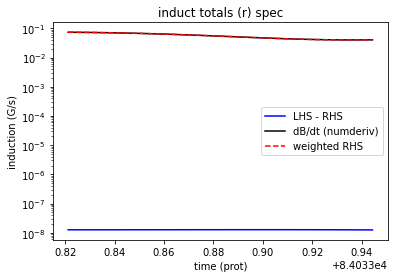

In [14]:
# plot the B_r equation
plt.plot(t[2:], my_abs(br_dt - br_rhs, subl0=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(br_dt, subl0=True)[ir0, :], 'k', label='dB/dt (numderiv)')
plt.plot(t[2:], my_abs(br_rhs, subl0=True)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec')

Text(0.5, 1.0, 'induct totals (t) spec')

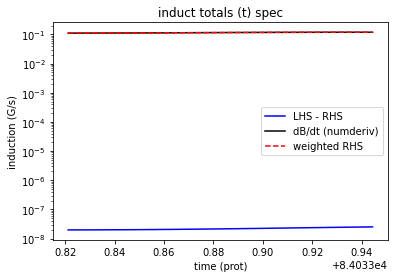

In [15]:
# plot the B_t equation
plt.plot(t[2:], my_abs(bt_dt - bt_rhs, subl0=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(bt_dt, subl0=True)[ir0, :], 'k', label='dB/dt (numderiv)')
plt.plot(t[2:], my_abs(bt_rhs, subl0=True)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (t) spec')

Text(0.5, 1.0, 'induct totals (p) spec')

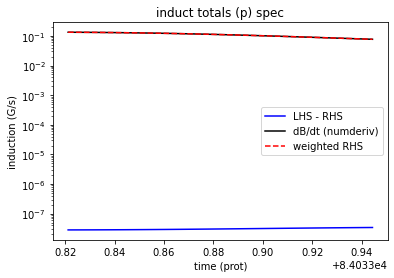

In [16]:
# plot the B_p equation
plt.plot(t[2:], my_abs(bp_dt - bp_rhs, subl0=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(bp_dt, subl0=True)[ir0, :], 'k', label='dB/dt (numderiv)')
plt.plot(t[2:], my_abs(bp_rhs, subl0=True)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (p) spec')

In [17]:
# make a definition of "error" (relative difference between two quantities in terms of "my_abs" above)
# for this, will average over time axis (axis = 1)
# returns "errors" at each radius sampled (array of shape (nr,))
def get_err(quant1, quant2, sslice=False, subl0=False):
    numer = np.mean(my_abs(quant1 - quant2, sslice=sslice, subl0=subl0),axis=1) # difference
    denom = np.mean(my_abs(quant1 + quant2, sslice=sslice, subl0=subl0),axis=1)/2 # average
    return numer/denom

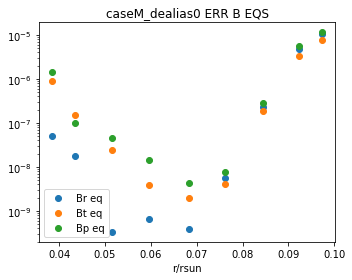

In [18]:
# plot errors in stream function equations (ignore l = 0 bit)
rsun = 6.96e10
rr = spec.radius/rsun
plt.figure(figsize=(5, 4))
plt.scatter(rr, get_err(br_dt, br_rhs, subl0=True), label='Br eq')
plt.scatter(rr, get_err(bt_dt, bt_rhs), label='Bt eq')
plt.scatter(rr, get_err(bp_dt, bp_rhs), label='Bp eq')
plt.yscale('log')
plt.xlabel('r/rsun')
plt.title(dirtag + ' ERR B EQS')
plt.legend()
plt.tight_layout()
plt.savefig(dirtag + '_err_ind.pdf')

In [19]:
# print these errors
print ('Br eq err = ', get_err(br_dt, br_rhs, subl0=True))
print ('Bt eq err = ', get_err(bt_dt, bt_rhs))
print ('Bp eq err = ', get_err(bp_dt, bp_rhs))

Br eq err =  [1.02400576e-05 4.67991603e-06 2.30036803e-07 5.55914680e-09
 3.94721658e-10 6.47657093e-10 3.33914807e-10 1.73098646e-08
 5.14699103e-08]
Bt eq err =  [7.61724015e-06 3.26613899e-06 1.88789174e-07 4.16848934e-09
 1.94112093e-09 3.78117829e-09 2.35216484e-08 1.51548689e-07
 8.83944574e-07]
Bp eq err =  [1.13554342e-05 5.62603419e-06 2.83641671e-07 7.51665176e-09
 4.33944572e-09 1.42655313e-08 4.45741960e-08 9.87907115e-08
 1.42003486e-06]
